In [1]:
import gc
from itertools import combinations
import pathlib
from typing import Any, Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import polars as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

gc.enable()
pd.set_option('display.max_columns', 200)
warnings.simplefilter('ignore')

In [2]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df.drop(columns=['row_id', 'time_id'], inplace=True)
display(train_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184


In [3]:
cast_dtypes = {
    'stock_id': np.int16,
    'date_id': np.int16,
    'seconds_in_bucket': np.int16,
    'imbalance_size': np.float32,
    'imbalance_buy_sell_flag': np.int16,
    'reference_price': np.float32,
    'matched_size': np.float32,
    'far_price': np.float32,
    'near_price': np.float32,
    'bid_price': np.float32,
    'bid_size': np.float32,
    'ask_price': np.float32,
    'ask_size': np.float32,
    'wap': np.float32,
    'target': np.float32
}

display(train_df.dtypes)
train_df = train_df.astype(cast_dtypes)
display(train_df)

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
target                     float64
dtype: object

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,NaN,NaN,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010201
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,NaN,NaN,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276
5237976,196,480,540,3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077
5237977,197,480,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443
5237978,198,480,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184


## calculdate index wap

In [4]:
weights = np.array([
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
])

index_wap = (
    train_df
    .groupby(['date_id', 'seconds_in_bucket'])
    .apply(lambda x: (weights[x['stock_id']] * x['wap']).sum())
)
index_wap = pd.DataFrame(index_wap, columns=['index_wap'])
train_df = train_df.merge(index_wap, on=['date_id', 'seconds_in_bucket'])
display(train_df)

del index_wap
gc.collect()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,index_wap
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704,0.961000
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986,0.961000
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950,0.961000
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,NaN,NaN,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010201,0.961000
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,NaN,NaN,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849,0.961000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276,0.998756
5237976,196,480,540,3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077,0.998756
5237977,197,480,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443,0.998756
5237978,198,480,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184,0.998756


0

## Standardization

In [5]:
train_df = train_df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).sort_index().unstack(level=0)
#train_df.columns = [col[0] + '_' + str(col[1]) for col in train_df.columns]
train_df.reset_index(drop=False, inplace=True)
display(train_df)

date_id seconds_in_bucket imbalance_size                 \
stock_id                                        0              1   
0              0                 0   3.180603e+06  166603.906250   
1              0                10   1.299773e+06  165923.203125   
2              0                20   1.299773e+06  165923.203125   
3              0                30   1.299773e+06  165923.203125   
4              0                40   1.218204e+06  162349.468750   
...          ...               ...            ...            ...   
26450        480               500   0.000000e+00   88468.406250   
26451        480               510   0.000000e+00  310778.500000   
26452        480               520   4.755137e+05  310778.500000   
26453        480               530   4.755137e+05  310778.500000   
26454        480               540   4.755137e+05   43854.511719   

                                                                              \
stock_id              2            3             4            5            6   
0         302879.875000  11917682.00  4.475500e+05        0.000  969969.3750   
1         184766.203125  10874034.00  4.177422e+05        0.000  682359.4375   
2         169764.640625  10874034.00  4.177422e+05        0.000  682359.4375   
3         169764.640625  10874034.00  4.136907e+05        0.000  682359.4375   
4         169764.640625  11215097.00  4.625985e+05        0.000  649503.3125   
...                 ...          ...           ...          ...          ...   
26450     376011.281250   3816029.25  2.275394e+06  1201779.125  543475.0000   
26451     376011.281250   3904029.50  2.828696e+06  1253139.000  784400.6875   
26452     260569.234375   3650977.00  2.393021e+06  1171907.250  989317.5000   
26453     184125.234375   3650977.00  2.750278e+06   966749.500  784400.6875   
26454     184125.234375   3635484.00  2.750278e+06  1063551.250  998598.1250   

                                                                           \
stock_id           7             8           9           10            11   
0         9412959.00  2.394876e+06  3039700.75  10482752.00  1.506120e+06   
1         8473527.00  1.492459e+06  2764209.00   9821786.00  1.363049e+06   
2         8473527.00  1.492459e+06  2727039.00   9821786.00  1.348954e+06   
3         8473527.00  1.438227e+06  2727039.00   9821786.00  1.417318e+06   
4         8330877.00  1.271193e+06  2732800.25   9762741.00  1.443160e+06   
...              ...           ...         ...          ...           ...   
26450     3867245.25  6.144203e+05        0.00   3183419.50  1.719481e+05   
26451     2625058.50  6.144203e+05        0.00   2937379.25  1.513617e+05   
26452     2514655.75  6.144203e+05        0.00   2954031.00  1.166565e+05   
26453     2620011.50  6.144203e+05        0.00   2958917.00  9.756872e+04   
26454     2469864.00  8.815596e+05        0.00   2943760.75  9.165307e+04   

                                                                          \
stock_id            12           13         14          15            16   
0         1.173994e+07  5749286.000  8899495.0  4469771.00  4.724994e+05   
1         1.019306e+07  4377985.500  7655566.5  4305821.50  3.554734e+05   
2         1.016820e+07  4377985.500  7542594.0  4305821.50  3.554734e+05   
3         1.016820e+07  4377985.500  7604327.5  4305821.50  3.554734e+05   
4         9.954726e+06  4345166.000  7043170.5  4305821.50  3.098717e+05   
...                ...          ...        ...         ...           ...   
26450     2.289909e+06  1494228.375  4803267.5  3014207.75  1.141023e+06   
26451     6.411293e+05  2204005.750  4745250.0  3408433.25  1.141023e+06   
26452     6.411293e+05  2155668.500  4725260.5  2924004.75  1.194074e+06   
26453     2.134538e+06  2155668.500  4725260.5  2910797.75  1.036974e+06   
26454     2.687820e+06  2685969.500  4801805.0  1777118.75  1.036974e+06   

                                                                      \
stock_id            

In [6]:
train_df.set_index(['date_id', 'seconds_in_bucket'], inplace=True)

train_targets = train_df['target']
train_features = train_df.drop(columns=['target'])

train_targets = train_targets.reset_index().fillna(0).set_index(['date_id', 'seconds_in_bucket'])
train_features = train_features.reset_index().fillna(train_df.mean()).set_index(['date_id', 'seconds_in_bucket'])

display(train_targets)
display(train_features)

stock_id                          0          1         2         3         4  \
date_id seconds_in_bucket                                                      
0       0                 -3.029704  -5.519986 -8.389950 -4.010201 -7.349849   
        10                 0.389814  -1.620054 -7.460117 -1.040101 -6.719828   
        20                 4.220009  -6.459951 -6.380081 -2.030134 -0.690222   
        30                 5.450249  -5.149841 -5.819798  1.130104 -2.589822   
        40                 3.169775  -6.750226 -0.280142 -2.350211 -4.900098   
...                             ...        ...       ...       ...       ...   
480     500                3.999472   2.850294 -4.450083  1.720190  1.939535   
        510                3.190041   3.169775 -5.559921  4.669428  2.139807   
        520               -0.169873   5.689859 -5.310178  5.639791  1.660585   
        530                3.110170  10.650158 -5.239844  5.229712  0.300407   
        540                0.760555  15.859604 -1.549721  3.160238  1.009703   

stock_id                          5         6          7         8         9  \
date_id seconds_in_bucket                                                      
0       0                  6.779432 -2.499819  -1.959801 -5.970001  7.970333   
        10                 7.710457 -4.280210  -8.010268 -0.780225 -0.640154   
        20                 1.009703  2.930164 -12.069941 -4.119873 -3.250241   
        30                -3.089905  0.560284  -6.909966 -1.090169 -6.759763   
        40                -2.070069  2.199411  -1.209974 -3.100038 -8.199811   
...                             ...       ...        ...       ...       ...   
480     500               -4.569888 -0.630021  -1.729727 -0.680089  3.540516   
        510                1.679659 -0.360012  -3.240108  2.609491  1.679659   
        520                2.110004 -1.000166  -4.529953  5.409718  0.350475   
        530               -2.030134 -1.180172  -1.310110  3.240108  0.220537   
        540                2.340078  1.410246  -1.260042  3.679991 -1.609921   

stock_id                         10         11        12         13        14  \
date_id seconds_in_bucket                                                       
0       0                  5.350113   2.559423  8.399487 -10.750294  2.319813   
        10                 4.869699   5.400181  4.990101  -4.529953 -1.170039   
        20                 2.260208   1.519918  9.189844  -5.189776  1.469851   
        30                 3.859997 -13.610125  8.020401  -5.540252 -0.770092   
        40                 5.320311 -21.839737  7.699728  -4.040003 -1.389980   
...                             ...        ...       ...        ...       ...   
480     500               -1.950264   3.340244 -0.280142  -1.220107 -0.510216   
        510               -6.750226  -3.709793 -0.389814  -0.140071  2.870560   
        520               -7.669926  -2.610087 -2.589822   0.629425  2.260208   
        530               -9.829998  -6.570220 -3.139973   3.010035 -3.219843   
        540               -0.230074  -1.469851 -0.110269   1.029968 -2.779961   

stock_id                         15        16         17         18  \
date_id seconds_in_bucket                                             
0       0                  1.720190 -8.170009  -3.589988 -11.439919   
        10                 1.280308  4.459620 -13.880134   1.620054   
        20                -1.360178 -2.589822 -16.229748   8.100271   
        30                -2.779961 -0.839829 -11.889935   8.939505   
        40                -1.059771  7.289648 -15.770197   8.319616   
...                             ...       ...        ...        ...   
480     500                0.059605 -1.379848   2.239943   0.790358   
        510               -2.380013 -0.450015   0.519753   0.410080   
        520               -0.650287 -2.359748   3.570318   0.419617   
        530               -2.660155 -1.130104   5.029440   0.339746   
        540 

imbalance_size                                \
stock_id                               0              1              2   
date_id seconds_in_bucket                                                
0       0                   3.180603e+06  166603.906250  302879.875000   
        10                  1.299773e+06  165923.203125  184766.203125   
        20                  1.299773e+06  165923.203125  169764.640625   
        30                  1.299773e+06  165923.203125  169764.640625   
        40                  1.218204e+06  162349.468750  169764.640625   
...                                  ...            ...            ...   
480     500                 0.000000e+00   88468.406250  376011.281250   
        510                 0.000000e+00  310778.500000  376011.281250   
        520                 4.755137e+05  310778.500000  260569.234375   
        530                 4.755137e+05  310778.500000  184125.234375   
        540                 4.755137e+05   43854.511719  184125.234375   

                                                                   \
stock_id                             3             4            5   
date_id seconds_in_bucket                                           
0       0                  11917682.00  4.475500e+05        0.000   
        10                 10874034.00  4.177422e+05        0.000   
        20                 10874034.00  4.177422e+05        0.000   
        30                 10874034.00  4.136907e+05        0.000   
        40                 11215097.00  4.625985e+05        0.000   
...                                ...           ...          ...   
480     500                 3816029.25  2.275394e+06  1201779.125   
        510                 3904029.50  2.828696e+06  1253139.000   
        520                 3650977.00  2.393021e+06  1171907.250   
        530                 3650977.00  2.750278e+06   966749.500   
        540                 3635484.00  2.750278e+06  1063551.250   

                                                                              \
stock_id                             6           7             8           9   
date_id seconds_in_bucket                                                      
0       0                  969969.3750  9412959.00  2.394876e+06  3039700.75   
        10                 682359.4375  8473527.00  1.492459e+06  2764209.00   
        20                 682359.4375  8473527.00  1.492459e+06  2727039.00   
        30                 682359.4375  8473527.00  1.438227e+06  2727039.00   
        40                 649503.3125  8330877.00  1.271193e+06  2732800.25   
...                                ...         ...           ...         ...   
480     500                543475.0000  3867245.25  6.144203e+05        0.00   
        510                784400.6875  2625058.50  6.144203e+05        0.00   
        520                989317.5000  2514655.75  6.144203e+05        0.00   
        530                784400.6875  2620011.50  6.144203e+05        0.00   
        540                998598.1250  2469864.00  8.815596e+05        0.00   

                                                                    \
stock_id                            10            11            12   
date_id seconds_in_bucket                                            
0       0                  10482752.00  1.506120e+06  1.173994e+07   
        10                  9821786.00  1.363049e+06  1.019306e+07   
        20                  9821786.00  1.348954e+06  1.016820e+07   
        30                  9821786.00  1.417318e+06  1.016820e+07   
        40                  9762741.00  1.443160e+06  9.954726e+06   
...                                ...           ...           ...   
480     500                 3183419.50  1.719481e+05  2.289909e+06   
        510                 2937379.25  1.513617e+05  6.411293e+05   
        520                 2954031.00  1.166565e+05  6.411293e+05   
        530                 2958917.00  9.756872e+04  2.13453

In [7]:
feature_scaler = StandardScaler()
scaled_train_features = feature_scaler.fit_transform(train_features)
train_features = pd.DataFrame(scaled_train_features, index=train_features.index, columns=train_features.columns)
display(train_features)

imbalance_size                                \
stock_id                               0         1         2         3   
date_id seconds_in_bucket                                                
0       0                      -0.123790 -0.355182 -0.096927  0.193851   
        10                     -0.349821 -0.355869 -0.104250  0.115620   
        20                     -0.349821 -0.355869 -0.105180  0.115620   
        30                     -0.349821 -0.355869 -0.105180  0.115620   
        40                     -0.359623 -0.359476 -0.105180  0.141186   
...                                  ...       ...       ...       ...   
480     500                    -0.506023 -0.434044 -0.092392 -0.413442   
        510                    -0.506023 -0.209666 -0.092392 -0.406845   
        520                    -0.448877 -0.209666 -0.099550 -0.425814   
        530                    -0.448877 -0.209666 -0.104290 -0.425814   
        540                    -0.448877 -0.479072 -0.104290 -0.426975   

                                                                             \
stock_id                          4         5         6         7         8   
date_id seconds_in_bucket                                                     
0       0                 -0.595983 -0.441886 -0.177140  0.042732 -0.447499   
        10                -0.601267 -0.441886 -0.271486 -0.036842 -0.519119   
        20                -0.601267 -0.441886 -0.271486 -0.036842 -0.519119   
        30                -0.601985 -0.441886 -0.271486 -0.036842 -0.523423   
        40                -0.593316 -0.441886 -0.282264 -0.048925 -0.536679   
...                             ...       ...       ...       ...       ...   
480     500               -0.272003 -0.208117 -0.317045 -0.427013 -0.588804   
        510               -0.173932 -0.198127 -0.238013 -0.532232 -0.588804   
        520               -0.251154 -0.213928 -0.170793 -0.541583 -0.588804   
        530               -0.187832 -0.253835 -0.238013 -0.532659 -0.588804   
        540               -0.187832 -0.235005 -0.167749 -0.545377 -0.567602   

                                                                             \
stock_id                          9        10        11        12        13   
date_id seconds_in_bucket                                                     
0       0                  0.146695  2.409868 -0.175272  0.030231  0.500996   
        10                 0.101136  2.220976 -0.207399 -0.063467  0.199699   
        20                 0.094989  2.220976 -0.210564 -0.064973  0.199699   
        30                 0.094989  2.220976 -0.195213 -0.064973  0.199699   
        40                 0.095942  2.204102 -0.189410 -0.077903  0.192489   
...                             ...       ...       ...       ...       ...   
480     500               -0.355990  0.323849 -0.474862 -0.542175 -0.433909   
        510               -0.355990  0.253535 -0.479485 -0.642044 -0.277959   
        520               -0.355990  0.258294 -0.487278 -0.642044 -0.288579   
        530               -0.355990  0.259690 -0.491564 -0.551586 -0.288579   
        540               -0.355990  0.255359 -0.492893 -0.518073 -0.172064   

                                                                             \
stock_id                         14        15        16        17        18   
date_id seconds_in_bucket                                                     
0       0                 -0.219468 -0.059523 -0.299030  0.217574 -0.256951   
        10                -0.282157 -0.068079 -0.334093  0.137882 -0.259727   
        20                -0.287850 -0.068079 -0.334093  0.137882 -0.260675   
        30                -0.284739 -0.068079 -0.334093  0.137882 -0.264139   
        40                -0.313019 -0.068079 -0.347757  0.146990 -0.264810   
...                             ...       ...       ...       ...       ...   
480     500               -0.425901 -0.135482 -0.098725 -0.60448

In [8]:
train_targets = train_targets.stack().to_frame(name='target')
train_features = train_features.stack()
display(train_targets)
display(train_features)

train_df = train_features.merge(train_targets, on=['date_id', 'seconds_in_bucket', 'stock_id'])
train_df = train_df.reset_index()
display(train_df)

target
date_id seconds_in_bucket stock_id          
0       0                 0        -3.029704
                          1        -5.519986
                          2        -8.389950
                          3        -4.010201
                          4        -7.349849
...                                      ...
480     540               195       2.310276
                          196      -8.220077
                          197       1.169443
                          198      -1.540184
                          199      -6.530285

[5291000 rows x 1 columns]

imbalance_size  imbalance_buy_sell_flag  \
date_id seconds_in_bucket stock_id                                            
0       0                 0              -0.123790                 1.296863   
                          1              -0.355182                -1.204414   
                          2              -0.096927                -1.264633   
                          3               0.193851                -0.991699   
                          4              -0.595983                -1.020324   
...                                            ...                      ...   
480     540               195            -0.287520                -1.014811   
                          196            -0.381431                -1.056115   
                          197            -0.415648                 0.052190   
                          198            -0.690629                 1.164294   
                          199            -0.130721                -1.212345   

                                    reference_price  matched_size  \
date_id seconds_in_bucket stock_id                                  
0       0                 0               -0.013514     -0.587920   
                          1               -0.010669     -0.203281   
                          2               -0.216755     -0.144067   
                          3                0.132904     -1.030048   
                          4               -0.174727     -0.415184   
...                                             ...           ...   
480     540               195              0.263145     -0.029639   
                          196              0.330715      0.385916   
                          197             -1.804878     -0.055174   
                          198             -0.418837     -0.079588   
                          199              1.030357     -0.007214   

                                       far_price    near_price  bid_price  \
date_id seconds_in_bucket stock_id                                          
0       0                 0        -2.429043e-06  1.260186e-06   0.045707   
                          1        -1.224414e-06  3.986639e-07   0.148775   
                          2        -3.198455e-06 -4.385717e-06  -0.110096   
                          3         2.530073e-06  2.666419e-06   0.087447   
                          4         1.197395e-07 -5.949766e-07  -0.180061   
...                                          ...           ...        ...   
480     540               195       1.842801e-01  1.849932e-01   0.313008   
                          196       1.019913e-01  1.519994e-01   0.424505   
                          197      -3.320472e-01 -4.905285e-01  -1.740852   
                          198       2.647461e-02 -8.938655e-03  -0.499803   
                          199       2.123765e-01  2.334480e-01   1.131348   

                                    bid_size  ask_price  ask_size       wap  \
date_id seconds_in_bucket stock_id                                            
0       0                 0         0.326694   0.042618 -0.517854  0.094031   
                          1        -0.579880   0.095774 -0.075094  0.025371   
                          2         0.405029  -0.116524 -0.169643 -0.054289   
                          3        -0.654877   0.084585  9.233653  0.015618   
                          4        -0.281506   0.007628 -0.744400  0.073872   
...                                      ...        ...       ...       ...   
480     540               195      -0.129694   0.285438  5.523553  0.268684   
                          196       4.757508   0.386479  1.419666  0.434908   
                          197      -0.238008  -1.858161  4.230238 -1.814506   
                          198      -0.438653  -0.502914  2.605655 -0.551270   
                          199       1.740081   1.109875  2.757425  1.110894   

                                    index_wap  
date_id seconds_in_bucket stock_

,date_id,seconds_in_bucket,stock_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,index_wap,target
0,0,0,0,-0.123790,1.296863,-0.013514,-0.587920,-2.429043e-06,1.260186e-06,0.045707,0.326694,0.042618,-0.517854,0.094031,-2.826406,-3.029704
1,0,0,1,-0.355182,-1.204414,-0.010669,-0.203281,-1.224414e-06,3.986639e-07,0.148775,-0.579880,0.095774,-0.075094,0.025371,-2.826406,-5.519986
2,0,0,2,-0.096927,-1.264633,-0.216755,-0.144067,-3.198455e-06,-4.385717e-06,-0.110096,0.405029,-0.116524,-0.169643,-0.054289,-2.826406,-8.389950
3,0,0,3,0.193851,-0.991699,0.132904,-1.030048,2.530073e-06,2.666419e-06,0.087447,-0.654877,0.084585,9.233653,0.015618,-2.826406,-4.010201
4,0,0,4,-0.595983,-1.020324,-0.174727,-0.415184,1.197395e-07,-5.949766e-07,-0.180061,-0.281506,0.007628,-0.744400,0.073872,-2.826406,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5290995,480,540,195,-0.287520,-1.014811,0.263145,-0.029639,1.842801e-01,1.849932e-01,0.313008,-0.129694,0.285438,5.523553,0.268684,0.755524,2.310276
5290996,480,540,196,-0.381431,-1.056115,0.330715,0.385916,1.019913e-01,1.519994e-01,0.424505,4.757508,0.386479,1.419666,0.434908,0.755524,-8.220077
5290997,480,540,197,-0.415648,0.052190,-1.804878,-0.055174,-3.320472e-01,-4.905285e-01,-1.740852,-0.238008,-1.858161,4.230238,-1.814506,0.755524,1.169443
5290998,480,540,198,-0.690629,1.164294,-0.418837,-0.079588,2.647461e-02,-8.938655e-03,-0.499803,-0.438653,-0.502914,2.605655,-0.551270,0.755524,-1.540184


## Feature Engineering

In [9]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = pl.from_pandas(df)

    new_features0 = [
        (pl.col('date_id') % 5).alias('day_of_week'),
    ]
    new_features1 = [
        (pl.col('ask_price') - pl.col('bid_price')).alias('feature1'),
        (pl.col('ask_price') - pl.col('reference_price')).alias('feature2'),
        (pl.col('bid_price') - pl.col('reference_price')).alias('feature3'),
        (pl.col('ask_price') - pl.col('wap')).alias('feature4'),
        (pl.col('bid_price') - pl.col('wap')).alias('feature5'),
        (pl.col('far_price') - pl.col('near_price')).alias('feature6'),
        (pl.col('far_price') - pl.col('reference_price')).alias('feature7'),
        (pl.col('near_price') - pl.col('reference_price')).alias('feature8'),
        (pl.col('index_wap') - pl.col('reference_price')).alias('feature9'),
        (pl.col('index_wap') - pl.col('ask_price')).alias('feature10'),
        (pl.col('index_wap') - pl.col('bid_price')).alias('feature11'),
        (pl.col('index_wap') - pl.col('far_price')).alias('feature12'),
        (pl.col('index_wap') - pl.col('near_price')).alias('feature13'),
        (pl.col('index_wap') - pl.col('wap')).alias('feature14'),
        (pl.col('ask_size') - pl.col('bid_size')).alias('feature15'),
        (pl.col('ask_size') - pl.col('matched_size')).alias('feature16'),
        (pl.col('bid_size') - pl.col('matched_size')).alias('feature17'),
        (pl.col('imbalance_size') - pl.col('matched_size')).alias('feature18'),
        (pl.col('ask_price') + pl.col('bid_price')).alias('feature19'),
        (pl.col('far_price') + pl.col('near_price')).alias('feature20'),
        (pl.col('ask_size') + pl.col('bid_size')).alias('feature21'),
        ((pl.col('ask_price') - pl.col('bid_price')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature22'),
        ((pl.col('ask_price') - pl.col('reference_price')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature23'),
        ((pl.col('bid_price') - pl.col('reference_price')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature24'),
        ((pl.col('ask_price') - pl.col('wap')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature25'),
        ((pl.col('bid_price') - pl.col('wap')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature26'),
        ((pl.col('ask_price') - pl.col('bid_price')) * ((pl.col('matched_size') - pl.col('imbalance_size')) / (pl.col('matched_size') + pl.col('imbalance_size')))).alias('feature27'),
        ((pl.col('ask_price') - pl.col('reference_price')) * ((pl.col('matched_size') - pl.col('imbalance_size')) / (pl.col('matched_size') + pl.col('imbalance_size')))).alias('feature28'),
        ((pl.col('bid_price') - pl.col('reference_price')) * ((pl.col('matched_size') - pl.col('imbalance_size')) / (pl.col('matched_size') + pl.col('imbalance_size')))).alias('feature29'),
        ((pl.col('ask_price') - pl.col('wap')) * ((pl.col('matched_size') - pl.col('imbalance_size')) / (pl.col('matched_size') + pl.col('imbalance_size')))).alias('feature30'),
        ((pl.col('bid_price') - pl.col('wap')) * ((pl.col('matched_size') - pl.col('imbalance_size')) / (pl.col('matched_size') + pl.col('imbalance_size')))).alias('feature31'),

        (pl.col('bid_price') / pl.col('ask_price')).alias('feature32'),
        (pl.col('reference_price') / pl.col('ask_price')).alias('feature33'),
        (pl.col('reference_price') / pl.col('bid_price')).alias('feature34'),
        (pl.col('wap') / pl.col('ask_price')).alias('feature35'),
        (pl.col('wap') / pl.col('bid_price')).alias('feature36'),
        (pl.col('index_wap') / pl.col('ask_price')).alias('feature37'),
        (pl.col('index_wap') / pl.col('bid_price')).alias('feature38'),
        (pl.col('index_wap') / pl.col('reference_price')).alias('feature39'),
        (pl.col('index_wap') / pl.col('wap')).alias('feature40'),

        (pl.col('bid_size') / pl.col('ask_size')).alias('feature41'),
        (pl.col('ask_size') / pl.col('matched_size')).alias('feature42'),
        (pl.col('bid_size') / pl.col('matched_size')).alias('feature43'),
        (pl.col('bid_size') / pl.col('imbalance_size')).alias('feature44'),
        (pl.col('ask_size') / pl.col('imbalance_size')).alias('feature45'),
        (pl.col('matched_size') / pl.col('imbalance_size')).alias('feature46'),
    ]

    base_features = [
        'imbalance_size',
        'imbalance_buy_sell_flag',
        'matched_size',
        'reference_price',
        'far_price',
        'near_price',
        'bid_size',
        'bid_price',
        'ask_size',
        'ask_price',
        'wap',
        'index_wap',
    ]
    #base_features += [f'feature{i}' for i in range(1, 47)]
    
    new_features2 = [
        pl.col(base_features).sort_by(['date_id', 'seconds_in_bucket']).pct_change(n=1).over(['stock_id']).name.prefix('pct_change1_'),
        pl.col(base_features).sort_by(['date_id', 'seconds_in_bucket']).pct_change(n=6).over(['stock_id']).name.prefix('pct_change6_'),
        pl.col(base_features).sort_by(['date_id', 'seconds_in_bucket']).pct_change(n=12).over(['stock_id']).name.prefix('pct_change12_'),
    ]

    new_features3 = [
        ((pl.col(feature) - pl.col(feature).mean()) / pl.col(feature).std())
        .over(['date_id', 'seconds_in_bucket'])
        .alias(f'standardized_{feature}')
        for feature in base_features
    ]

    replace_inf = [
        pl.when(pl.col(feature).is_infinite()).then(None).otherwise(pl.col(feature)).name.keep()
        for feature in df.columns
    ]

    df = (
        df
        .with_columns(new_features0)
        .with_columns(new_features1)
        .with_columns(new_features2)
        .with_columns(new_features3)
        .with_columns(replace_inf)
        .drop(['row_id'])
        .to_pandas()
    )

    return df

In [10]:
train_df = preprocess(train_df)
train_df = train_df.dropna(subset=['target'])
display(train_df)

,date_id,seconds_in_bucket,stock_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,index_wap,target,day_of_week,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,pct_change1_imbalance_size,pct_change1_imbalance_buy_sell_flag,pct_change1_matched_size,pct_change1_reference_price,pct_change1_far_price,pct_change1_near_price,pct_change1_bid_size,pct_change1_bid_price,pct_change1_ask_size,pct_change1_ask_price,pct_change1_wap,pct_change1_index_wap,pct_change6_imbalance_size,pct_change6_imbalance_buy_sell_flag,pct_change6_matched_size,pct_change6_reference_price,pct_change6_far_price,pct_change6_near_price,pct_change6_bid_size,pct_change6_bid_price,pct_change6_ask_size,pct_change6_ask_price,pct_change6_wap,pct_change6_index_wap,pct_change12_imbalance_size,pct_change12_imbalance_buy_sell_flag,pct_change12_matched_size,pct_change12_reference_price,pct_change12_far_price,pct_change12_near_price,pct_change12_bid_size,pct_change12_bid_price,pct_change12_ask_size,pct_change12_ask_price,pct_change12_wap,pct_change12_index_wap,standardized_imbalance_size,standardized_imbalance_buy_sell_flag,standardized_matched_size,standardized_reference_price,standardized_far_price,standardized_near_price,standardized_bid_size,standardized_bid_price,standardized_ask_size,standardized_ask_price,standardized_wap,standardized_index_wap
0,0,0,0,-0.123790,1.296863,-0.013514,-0.587920,-2.429043e-06,1.260186e-06,0.045707,0.326694,0.042618,-0.517854,0.094031,-2.826406,-3.029704,0,-0.003089,0.056132,0.059221,-0.051414,-0.048324,-3.689229e-06,0.013511,0.013515,-2.812892,-2.869024,-2.872113,-2.826404,-2.826407,-2.920437,-0.844548,0.070066,0.914614,0.464131,0.088325,-1.168856e-06,-0.191160,-0.013649,0.247990,0.261638,-0.227145,-0.213496,-0.002015,0.036605,0.038620,-0.033529,-0.031514,1.072490,-0.317095,-0.295663,2.206389,2.057258,-66.319953,-61.837362,209.148405,-30.058143,-0.630860,0.880823,-0.555676,-2.639099,4.183333,4.749344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.216897,1.229335,-0.204950,-0.030230,-1.485665,0.371983,0.699365,0.471437,-0.398579,-0.122451,1.756440,-0.216491
1,0,0,1,-0.355182,-1.204414,-0.010669,-0.203281,-1.224414e-06,3.986639e-07,0.148775,-0.579880,0.095774,-0.075094,0.025371,-2.826406,-5.519986,0,-0.053001,0.106443,0.159444,0.070403,0.123404,-1.623078e-06,0.010667,0.010669,-2.815737,-2.922180,-2.975181,-2.826405,-2.826406,-2.851777,0.504787,0.128187,-0.376599,-0.151900,0.244549,-8.257497e-07,-0.654974,0.040848,-0.082035,-0.122883,-0.054259,-0.095107,0.014416,-0.028952,-0.043368,-0.019149,-0.033566,1.553400,-0.111394,-0.071709,0.264908,0.170534,-29.511214,-18.997814,264.927539,-111.401869,7.722076,0.369409,2.852603,1.632631,0.211424,0.572330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.458621,-1.179752,1.071054,-0.018572,-0.743831,0.096736,-0.471617,1.064140,0.104923,0.138530,0.300235,-0.216491
2,0,0,2,-0.096927,-1.264633,-0.216755,-0.144067,-3.198455e-06,-4.385717e-06,-0.110096,0.405029,-0.116524,-0.169643,-0.054289,-2.826406,-8.389950,0,-0.006428,0.100232,0.106659,-0.062235,-0.055807,1.187262e-06,0.216752,0.216751,-2.609651,-2.709882,-2.716310,-2.826403,-2.826402,-2.772117,-0.574672,-0.025576,0.549096,0.047141,-0.226619,-7.584171e-06,0.235386,0.015693,-0.244705,-0.260399,0.151940,0.136246,-0.001257,0.019606,0.020864,-0.012174,-0.010916,0.944836,1.860181,1.968788,

## train lightgbm models using cross validation

In [11]:
def train(
        dataset: pd.DataFrame,
        model_params: Dict[str, Any],
        outputs_dir: pathlib.Path,
        step: int,
        gap: int,
    ):
    
    target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
    feature_columns = [col for col in dataset.columns if col not in ['date_id', 'target']]
    days= np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    fimps = []
    history = {
        'train_mae': [],
        'valid_mae': [],
    }

    valid_days = days[-step:]
    valid_X = dataset.query('date_id in @valid_days')[feature_columns]
    valid_y = dataset.query('date_id in @valid_days')[target_columns]

    train_day_lower_limits = np.arange(0, 360, step+gap)

    mean_best_iteration = 0

    for k, lower_limit in enumerate(train_day_lower_limits):
        train_days = np.arange(lower_limit, lower_limit+step)
        print(f'fold {k+1}')
        print(train_days)
        print(valid_days)
        
        plot_time(days, train_days, valid_days)
        
        train_X = dataset.query('date_id in @train_days')[feature_columns]
        train_y = dataset.query('date_id in @train_days')[target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')

        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(500),
        ]
        
        train_dataset = lgb.Dataset(
            train_X,
            train_y['target'],
            #categorical_feature=['imbalance_buy_sell_flag'],
        )

        valid_dataset = lgb.Dataset(
            valid_X,
            valid_y['target'],
            #categorical_feature=['imbalance_buy_sell_flag'],
        )
        
        model = lgb.train(
            params=model_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=6000,
        )
        model.save_model(
            outputs_dir.joinpath(f'lightgbm_fold{k+1}.txt'),
            num_iteration=model.best_iteration
        )
        
        fimp = model.feature_importance(importance_type='gain')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)

        train_pred = model.predict(train_X, num_iteration=model.best_iteration)
        valid_pred = model.predict(valid_X, num_iteration=model.best_iteration)

        valid_y[f'regression_fold{k+1}'] = valid_pred

        history['train_mae'].append(mean_absolute_error(train_y['target'], train_pred))
        history['valid_mae'].append(mean_absolute_error(valid_y['target'], valid_pred))

        mean_best_iteration += model.best_iteration
        
        del train_X, train_y, train_dataset, valid_dataset, model, fimp
        del train_pred, valid_pred
        gc.collect()

    del valid_X
    gc.collect()

    history = pd.DataFrame.from_dict(history)

    mean_best_iteration /= len(train_day_lower_limits)
    
    fimps = pd.concat(fimps, axis=1)
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    fimps.index = [f'{len(fimps)-i}_{idx}' for i, idx in enumerate(fimps.index)]
    
    valid_y['regression'] = valid_y[[f'regression_fold{k+1}' for k in range(len(train_day_lower_limits))]].mean(axis=1)
    test_y_mae = mean_absolute_error(valid_y['target'], valid_y['regression'])
    print(f'test_y mae: {test_y_mae:.4f}')
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'test_y rmse': test_y_mae,
            },
            f,
            default_flow_style=False
        )
    return history, valid_y, fimps, mean_best_iteration


def plot_time(all_time, train_time, valid_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid+test', height=0.6, width=[len(train_time), len(valid_time)],
            left=[train_time.min(), valid_time.min()], color=['tab:orange', 'tab:green', 'tab:red'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2,
               valid_time.min()+len(valid_time)//2]
    ycenter = [0, 1, 1, 1]
    width = [f'all\n{len(all_time)}', f'train\n{len(train_time)}', f'valid\n{len(valid_time)}']
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    ax.set_xticks([train_time.min(), train_time.max(), valid_time.min(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

fold 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
[384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479]


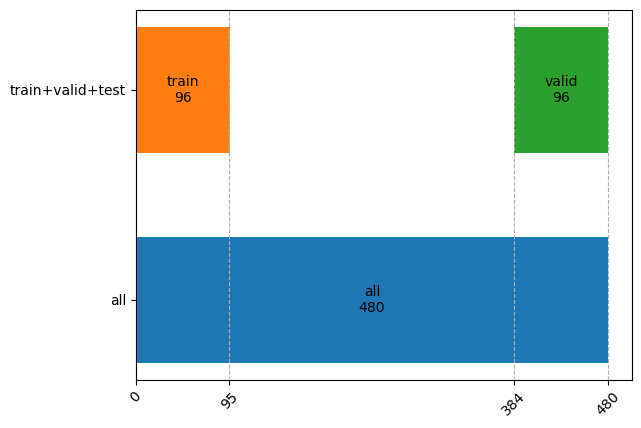

train_X.shape: (1056000, 109), train_y.shape: (1056000, 4)
valid_X.shape: (1056000, 109), valid_y.shape: (1056000, 4)


KeyboardInterrupt: 

In [13]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'mae',
    'metric': 'mae',
    'learning_rate': 1e-02,
    'seed': 42,
    'max_depth':  10,
    'num_leaves': 256,
    'min_data_in_leaf': 50,
    'feature_fraction': 0.8,
    'feature_fraction_bynode': 0.6,
    'lambda_l2': 0.0,
    'bagging_fraction': 0.4,
    'n_jobs': 4,
    'verbose': -1,
}

step = 60
gap = 0

history, result, fimps, mean_best_iteration = train(
    dataset=train_df,
    model_params=params,
    outputs_dir=outputs_dir_path,
    step=step,
    gap=gap,
)

In [ ]:
display(result)
print(fimps.shape)
display(fimps.tail(50))

_, ax = plt.subplots(figsize=(12, 36))
fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3, ax=ax)  
plt.tight_layout()
plt.show()

fimps_quantile_th = fimps['mean_fimps'].quantile(q=0.2)
display(fimps.query('mean_fimps < @fimps_quantile_th').index)

In [ ]:
mae_per_sotck = result.groupby('stock_id')[['target', 'regression']].apply(lambda x: np.mean(abs(x['target'] - x['regression'])))
display(mae_per_sotck.describe())

_, ax = plt.subplots()
ax.plot(mae_per_sotck.values, marker='o', linestyle=':')
plt.show()

display(mae_per_sotck[mae_per_sotck <= 6])
display(mae_per_sotck[mae_per_sotck <= 6].describe())

display(mae_per_sotck[mae_per_sotck > 6])
display(mae_per_sotck[mae_per_sotck > 6].describe())

In [ ]:
_, axs = plt.subplots(2, 1, sharex=True)
bins = np.linspace(-100, 100, 100)
axs[0].hist(result.query('stock_id in @mae_per_sotck[@mae_per_sotck <= 6].index')['target'], bins=bins, histtype='step', density=True)
axs[0].hist(result.query('stock_id in @mae_per_sotck[@mae_per_sotck > 6].index')['target'], bins=bins, histtype='step', density=True)
axs[1].hist(result.query('stock_id in @mae_per_sotck[@mae_per_sotck <= 6].index')['regression'], bins=bins, histtype='step', density=True)
axs[1].hist(result.query('stock_id in @mae_per_sotck[@mae_per_sotck > 6].index')['regression'], bins=bins, histtype='step', density=True)
plt.show()

In [ ]:
fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(
    go.Scatter(
        x=result.query('stock_id==0').index, y=result.query('stock_id==0')['target'],
        name='target', mode='lines+markers', marker={'size': 5},
    ),
)
fig.add_trace(
    go.Scatter(
        x=result.query('stock_id==0').index, y=result.query('stock_id==0')['regression'],
        name='target', mode='lines+markers', marker={'size': 5},
    ),
)

In [ ]:
fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(
    go.Scatter(
        x=result.query('stock_id==1').index, y=result.query('stock_id==1')['target'],
        name='target', mode='lines+markers', marker={'size': 5},
    ),
)
fig.add_trace(
    go.Scatter(
        x=result.query('stock_id==1').index, y=result.query('stock_id==1')['regression'],
        name='target', mode='lines+markers', marker={'size': 5},
    ),
)

In [ ]:
_, ax = plt.subplots()
history.plot(marker='.', linestyle=':', ax=ax)
ax.set_xticks(range(0, len(history)))
ax.set_xticklabels([f'{i*step} days' for i in range(1, len(history)+1)])
ax.grid(axis='x')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [ ]:
_, ax = plt.subplots()
ax.hist2d(result['regression'], result['target'], bins=100, cmap='Blues', vmax=1e+03)
ax.plot([-100, 100], [-100, 100], color='tab:orange')
ax.set_xlabel('regression')
ax.set_ylabel('target')
plt.show()

r = np.corrcoef(result['regression'], result['target'])
print(f'correlation coeeficient: {r[0, 1]:.4f}')

## train lightgbm model using all data

In [ ]:
# target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
# feature_columns = [col for col in train_df.columns if col not in ['date_id', 'target']]

# callbacks = [
#     lgb.log_evaluation(500),
# ]

# train_dataset = lgb.Dataset(
#     train_df[feature_columns],
#     train_df[target_columns]['target'],
# )

# del train_df
# gc.collect()

# callbacks = [
#     lgb.log_evaluation(500),
# ]

# model = lgb.train(
#     params=params,
#     train_set=train_dataset,
#     callbacks=callbacks,
#     num_boost_round=int(mean_best_iteration),
# )

# model.save_model(
#     outputs_dir_path.joinpath(f'lightgbm_trained_using_alldata.txt'),
#     num_iteration=model.best_iteration,
# )